In [4]:
import sys
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer


In [5]:
def array_to_concatenated_string(array):
    """DO NOT MODIFY THIS FUNCTION.

    Turns an array of integers into a concatenated string of integers
    separated by commas. (Inverse of concatenated_string_to_array).
    """
    return ",".join(str(x) for x in array)


def concatenated_string_to_array(string):
    """DO NOT MODIFY THIS FUNCTION.

    Turns a concatenated string of integers separated by commas into
    an array of integers. (Inverse of array_to_concatenated_string).
    """
    return np.array([int(x) for x in string.split(",")])


def parse_input(giant_string):
    """DO NOT MODIFY THIS FUNCTION.

    Parse the input data into 3 arrays: the training data, training labels,
    and testing data.

    Dimensions of the input data are:
      - X_train: (250, 3)
      - Y_train: (250,)
      - X_test:  (50, 3)
    """
    X_train_part, Y_train_part, X_test_part = giant_string.split("XXX")

    X_train_row_strings = X_train_part.split("S")
    X_train_rows = [[float(x) for x in row.split(",")] for row in X_train_row_strings]
    X_train = np.array(X_train_rows)

    Y_train = concatenated_string_to_array(Y_train_part)

    X_test_row_strings = X_test_part.split("S")
    X_test_rows = [[float(x) for x in row.split(",")] for row in X_test_row_strings]
    X_test = np.array(X_test_rows)

    return X_train, Y_train, X_test


x               :  [0.53896774 0.79503606 0.27826503 0.        ]
amplitude vector:  [0.53896774 0.79503606 0.27826503 0.        ]
[0.46586604 0.47378893 0.22608081]
[0.46586604 0.47378893 0.22608081 0.3       ]
[0.6103353  0.62071515 0.29619051 0.39303271]
[ 1.0290968  -0.92499347  0.92499347 -0.79382966  0.79382966]


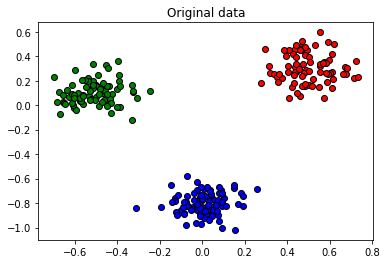

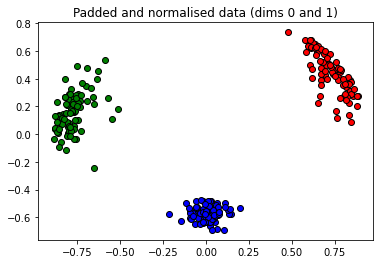

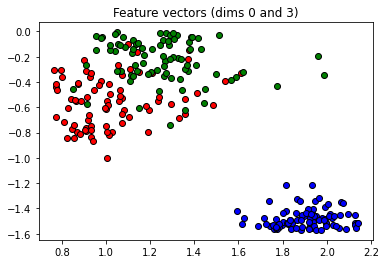

In [6]:
import matplotlib.pyplot as plt
def classify_data(X_train, Y_train, X_test):
    """Develop and train your very own variational quantum classifier.

    Use the provided training data to train your classifier. The code you write
    for this challenge should be completely contained within this function
    between the # QHACK # comment markers. The number of qubits, choice of
    variational ansatz, cost function, and optimization method are all to be
    developed by you in this function.

    Args:
        X_train (np.ndarray): An array of floats of size (250, 3) to be used as training data.
        Y_train (np.ndarray): An array of size (250,) which are the categorical labels
            associated to the training data. The categories are labeled by -1, 0, and 1.
        X_test (np.ndarray): An array of floats of (50, 3) to serve as testing data.

    Returns:
        str: The predicted categories of X_test, converted from a list of ints to a
            comma-separated string.
    """

    # Use this array to make a prediction for the labels of the data in X_test
    predictions = []

    # QHACK #
#     print(X_train.shape)
#     print(X_train[0])
    dev = qml.device("default.qubit", wires = 2)
    def get_angles(x):

        beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
        beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
        beta2 = 2 * np.arcsin(
            np.sqrt(x[2] ** 2 + x[3] ** 2)
            / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
        )

        return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])
    def statepreparation(a):
        qml.RY(a[0], wires=0)

        qml.CNOT(wires=[0, 1])
        qml.RY(a[1], wires=1)
        qml.CNOT(wires=[0, 1])
        qml.RY(a[2], wires=1)

        qml.PauliX(wires=0)
        qml.CNOT(wires=[0, 1])
        qml.RY(a[3], wires=1)
        qml.CNOT(wires=[0, 1])
        qml.RY(a[4], wires=1)
        qml.PauliX(wires=0)
    
    def layer(W):
        qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
        qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
        qml.CNOT(wires=[0, 1])
    
    @qml.qnode(dev)
    def circuit(weights, angles):
        qml.QubitStateVector(angles, wires=[0,1])
        #statepreparation(angles)
        
        for W in weights:
            layer(W)
        
        return qml.expval(qml.PauliZ(0))
    
    #########################
    x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
    #ang = get_angles(x)


    @qml.qnode(dev)
    def test(angles):
        qml.QubitStateVector(angles, wires=[0,1])
        #statepreparation(angles)

        return qml.expval(qml.PauliZ(0))


    test(x)

    print("x               : ", x)
    print("amplitude vector: ", np.real(dev.state))
    
    #########################
    def variational_classifier(var, angles):
        weights = var[0]
        bias = var[1]
        return circuit(weights, angles) + bias
    def square_loss(labels, predictions):
        loss = 0
        for l, p in zip(labels, predictions):
            loss = loss + (l - p) ** 2

        loss = loss / len(labels)
        return loss
    def accuracy(labels, predictions):

        loss = 0
        for l, p in zip(labels, predictions):
            if abs(l - p) < 1e-5:
                loss = loss + 1
        loss = loss / len(labels)

        return loss
    def cost(weights, features, lables):
        predictions = [variational_classifier(weights, f) for f in features]
        return square_loss(labels, predictions)
    print(X_train[0])
    padding = 0.3 * np.ones((len(X_train), 1))
    X_pad = np.c_[X_train, padding]
    print(X_pad[0])
    normalization = np.sqrt(np.sum(X_pad ** 2, -1))
    X_norm = (X_pad.T / normalization).T
    print(X_norm[0])
    features = np.array([get_angles(x) for x in X_norm])
    print(features[0])
    X = X_train
    Y = Y_train
    plt.figure()
    plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", edgecolors="k")
    plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", edgecolors="k")
    plt.scatter(X[:, 0][Y == 0], X[:, 1][Y == 0], c="g", marker="o", edgecolors="k")
    plt.title("Original data")
    plt.show()

    plt.figure()
    dim1 = 0
    dim2 = 1
    plt.scatter(
        X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
    )
    plt.scatter(
        X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
    )
    plt.scatter(
        X_norm[:, dim1][Y == 0], X_norm[:, dim2][Y == 0], c="g", marker="o", edgecolors="k"
    )
    plt.title("Padded and normalised data (dims {} and {})".format(dim1, dim2))
    plt.show()

    plt.figure()
    dim1 = 0
    dim2 = 3
    plt.scatter(
        features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
    )
    plt.scatter(
        features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
    )
    plt.scatter(
        features[:, dim1][Y == 0], features[:, dim2][Y == 0], c="g", marker="o", edgecolors="k"
    )
    plt.title("Feature vectors (dims {} and {})".format(dim1, dim2))
    plt.show()
    
    # QHACK #

    return array_to_concatenated_string(predictions)

with open("1.in") as file:
    X_train, Y_train, X_test = parse_input(file.read())
    output_string = classify_data(X_train, Y_train, X_test)
    print(f"{output_string}")

# if __name__ == "__main__":
#     # DO NOT MODIFY anything in this code block

#     X_train, Y_train, X_test = parse_input(sys.stdin.read())
#     output_string = classify_data(X_train, Y_train, X_test)
#     print(f"{output_string}")


In [49]:
import matplotlib.pyplot as plt
def classify_data(X_train, Y_train, X_test):
    """Develop and train your very own variational quantum classifier.

    Use the provided training data to train your classifier. The code you write
    for this challenge should be completely contained within this function
    between the # QHACK # comment markers. The number of qubits, choice of
    variational ansatz, cost function, and optimization method are all to be
    developed by you in this function.

    Args:
        X_train (np.ndarray): An array of floats of size (250, 3) to be used as training data.
        Y_train (np.ndarray): An array of size (250,) which are the categorical labels
            associated to the training data. The categories are labeled by -1, 0, and 1.
        X_test (np.ndarray): An array of floats of (50, 3) to serve as testing data.

    Returns:
        str: The predicted categories of X_test, converted from a list of ints to a
            comma-separated string.
    """

    # Use this array to make a prediction for the labels of the data in X_test
    predictions = []

    # QHACK #
#     print(X_train.shape)
#     print(X_train[0])
    dev = qml.device("default.qubit", wires = 2)
    
    def layer(W):
        qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
        qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
        qml.CNOT(wires=[0, 1])
    
    @qml.qnode(dev)
    def circuit(weights, x):
        qml.QubitStateVector(x, wires=[0, 1])
        #statepreparation(x)
        for W in weights:
            layer(W)
        
        return qml.expval(qml.PauliZ(0))
    
    def variational_classifier(var, angles):
        weights = var[0]
        bias = var[1]
        return circuit(weights, angles) + bias
    
    def square_loss(labels, predictions):
        loss = 0
        for l, p in zip(labels, predictions):
            loss = loss + (l - p) ** 2
        loss = loss / len(labels)
        return loss
    
    def get_label(p):
        if p < -0.3:
            return -1.0
        if p > 0.3:
            return 1.0
        return 0.0
    
    def accuracy(labels, predictions):
        loss = 0
        for l, p in zip(labels, predictions):
            if abs(l - p) < 1e-5:
                loss = loss + 1
        loss = loss / len(labels)
        return loss
    
    def cost(weights, features, labels):
        predictions = [variational_classifier(weights, f) for f in features]
        return square_loss(labels, predictions)
    
    ### Normalize training data
    padding = 0.3 * np.ones((len(X_train), 1))
    X_pad = np.c_[X_train, padding]
    normalization = np.sqrt(np.sum(X_pad ** 2, -1))
    X_norm = (X_pad.T / normalization).T
    ######################################
    
    features = X_norm
    print(X_train[0])
    print(X_pad[0])
    print(X_norm[0])
    print(features[0])
    #X_pad = np.c_[np.c_[X_train, padding], np.zeros((len(X_train), 1))]
    #features = np.array([get_angles(x) for x in X_norm])
    
    ### Normalize input test For later use
    padding = 0.3 * np.ones((len(X_test), 1))
    X_test_pad = np.c_[X_test, padding]
    normalization = np.sqrt(np.sum(X_test_pad ** 2, -1))
    X_test_norm = (X_test_pad.T / normalization).T
    ######################################
    
    np.random.seed(0)
    feats_train = X_norm
    Y = Y_train
    num_data = len(Y)
    num_train = 55
    feats_val = X_test_norm
    Y_val = [1,0,-1,0,-1,1,-1,-1,0,-1,1,-1,0,1,0,-1,-1,0,0,1,1,0,-1,0,0,-1,0,-1,0,0,1,1,-1,-1,-1,0,-1,0,1,0,-1,1,1,0,-1,-1,-1,-1,0,0]

    # optimization
    num_qubits = 2
    num_layers = 6
    var_init = (0.01 * np.random.randn(num_layers, num_qubits, 3), 0.0)
    
    opt = NesterovMomentumOptimizer(0.1)
    batch_size = 5
    
    var = var_init
    for it in range(60):
        
        batch_index = np.random.randint(0, num_train, (batch_size,))
        feats_train_batch = feats_train[batch_index]
        Y_train_batch = Y_train[batch_index]
        var = opt.step(lambda v: cost(v, feats_train_batch, Y_train_batch), var)
        
        predictions_train = [get_label(variational_classifier(var, f)) for f in feats_train]
        predictions_val = [get_label(variational_classifier(var, f)) for f in feats_val]
        
        # Compute accuracy on train and validation set
        acc_train = accuracy(Y_train, predictions_train)
        acc_val = accuracy(Y_val, predictions_val)
        print(
            "Iter: {:3d} | Cost: {:0.3f} | Acc train: {:0.3f} | Acc validation: {:0.3f} "
            "".format(it + 1, cost(var, features, Y), acc_train, acc_val)
        )
    
    # QHACK #
    
    
    predictions = [get_label(variational_classifier(var, f)) for f in feats_val]
    print(Y_val[0:15])
    print([int(x) for x in predictions][0:15])
    return array_to_concatenated_string(predictions)

with open("1.in") as file:
    X_train, Y_train, X_test = parse_input(file.read())
    output_string = classify_data(X_train, Y_train, X_test)
    print(f"{output_string}")

# if __name__ == "__main__":
#     # DO NOT MODIFY anything in this code block

#     X_train, Y_train, X_test = parse_input(sys.stdin.read())
#     output_string = classify_data(X_train, Y_train, X_test)
#     print(f"{output_string}")


[0.46586604 0.47378893 0.22608081]
[0.46586604 0.47378893 0.22608081 0.3       ]
[0.6103353  0.62071515 0.29619051 0.39303271]
[0.6103353  0.62071515 0.29619051 0.39303271]
Iter:   1 | Cost: 1.244 | Acc train: 0.180 | Acc validation: 0.220 
Iter:   2 | Cost: 0.853 | Acc train: 0.264 | Acc validation: 0.320 
Iter:   3 | Cost: 0.630 | Acc train: 0.616 | Acc validation: 0.540 
Iter:   4 | Cost: 0.366 | Acc train: 0.652 | Acc validation: 0.640 
Iter:   5 | Cost: 0.176 | Acc train: 0.824 | Acc validation: 0.800 
Iter:   6 | Cost: 0.121 | Acc train: 0.780 | Acc validation: 0.760 
Iter:   7 | Cost: 0.104 | Acc train: 0.804 | Acc validation: 0.760 
Iter:   8 | Cost: 0.091 | Acc train: 0.872 | Acc validation: 0.820 
Iter:   9 | Cost: 0.077 | Acc train: 0.928 | Acc validation: 0.880 
Iter:  10 | Cost: 0.065 | Acc train: 0.964 | Acc validation: 0.940 
Iter:  11 | Cost: 0.058 | Acc train: 0.956 | Acc validation: 0.940 
Iter:  12 | Cost: 0.064 | Acc train: 0.940 | Acc validation: 0.900 
Iter:  13 |

In [52]:
import matplotlib.pyplot as plt
def classify_data(X_train, Y_train, X_test):
    """Develop and train your very own variational quantum classifier.

    Use the provided training data to train your classifier. The code you write
    for this challenge should be completely contained within this function
    between the # QHACK # comment markers. The number of qubits, choice of
    variational ansatz, cost function, and optimization method are all to be
    developed by you in this function.

    Args:
        X_train (np.ndarray): An array of floats of size (250, 3) to be used as training data.
        Y_train (np.ndarray): An array of size (250,) which are the categorical labels
            associated to the training data. The categories are labeled by -1, 0, and 1.
        X_test (np.ndarray): An array of floats of (50, 3) to serve as testing data.

    Returns:
        str: The predicted categories of X_test, converted from a list of ints to a
            comma-separated string.
    """

    # Use this array to make a prediction for the labels of the data in X_test
    predictions = []

    # QHACK #
#     print(X_train.shape)
#     print(X_train[0])
    dev = qml.device("default.qubit", wires = 2)
    
    def layer(W):
        qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
        qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
        qml.CNOT(wires=[0, 1])
    def get_angles(x):

        beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
        beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
        beta2 = 2 * np.arcsin(np.sqrt(x[2] ** 2 + x[3] ** 2)/ np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2))

        return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

    def statepreparation(a):

        qml.RY(a[0], wires=0)

        qml.CNOT(wires=[0, 1])
        qml.RY(a[1], wires=1)
        qml.CNOT(wires=[0, 1])
        qml.RY(a[2], wires=1)

        qml.PauliX(wires=0)
        qml.CNOT(wires=[0, 1])
        qml.RY(a[3], wires=1)
        qml.CNOT(wires=[0, 1])
        qml.RY(a[4], wires=1)
        qml.PauliX(wires=0)

    @qml.qnode(dev)
    def circuit(weights, x):
        #qml.QubitStateVector(x, wires=[0, 1])
        statepreparation(x)
        for W in weights:
            layer(W)
        
        return qml.expval(qml.PauliZ(0))
    
    def variational_classifier(var, angles):
        weights = var[0]
        bias = var[1]
        return circuit(weights, angles) + bias
    
    def square_loss(labels, predictions):
        loss = 0
        for l, p in zip(labels, predictions):
            loss = loss + (l - p) ** 2
        loss = loss / len(labels)
        return loss
    
    def get_label(p):
        if p < -0.333:
            return -1.0
        if p > 0.333:
            return 1.0
        return 0.0
    
    def accuracy(labels, predictions):
        loss = 0
        for l, p in zip(labels, predictions):
            if abs(l - p) < 1e-5:
                loss = loss + 1
        loss = loss / len(labels)
        return loss
    
    def cost(weights, features, labels):
        predictions = [variational_classifier(weights, f) for f in features]
        return square_loss(labels, predictions)
    
    ### Normalize training data
    padding = 0.3 * np.ones((len(X_train), 1))
    X_pad = np.c_[np.c_[X_train, padding], np.zeros((len(X_train), 1))]
    normalization = np.sqrt(np.sum(X_pad ** 2, -1))
    X_norm = (X_pad.T / normalization).T
    ######################################
    
    features = X_norm
    print(X_train[0])
    print(X_pad[0])
    print(X_norm[0])
    print(features[0])
    #X_pad = np.c_[np.c_[X_train, padding], np.zeros((len(X_train), 1))]
    #features = np.array([get_angles(x) for x in X_norm])
    
    ### Normalize input test For later use
    padding = 0.3 * np.ones((len(X_test), 1))
    X_test_pad = np.c_[np.c_[X_test, padding], np.zeros((len(X_test), 1))]
    normalization = np.sqrt(np.sum(X_test_pad ** 2, -1))
    X_test_norm = (X_test_pad.T / normalization).T
    ######################################
    
    np.random.seed(0)
    feats_train = X_norm
    Y = Y_train
    num_data = len(Y)
    num_train = 50
    feats_val = X_test_norm
    Y_val = [1,0,-1,0,-1,1,-1,-1,0,-1,1,-1,0,1,0,-1,-1,0,0,1,1,0,-1,0,0,-1,0,-1,0,0,1,1,-1,-1,-1,0,-1,0,1,0,-1,1,1,0,-1,-1,-1,-1,0,0]

    # optimization
    num_qubits = 2
    num_layers = 6
    var_init = (0.01 * np.random.randn(num_layers, num_qubits, 3), 0.0)
    
    opt = NesterovMomentumOptimizer(0.1)
    batch_size = 5
    
    var = var_init
    for it in range(60):
        
        batch_index = np.random.randint(0, num_train, (batch_size,))
        feats_train_batch = feats_train[batch_index]
        Y_train_batch = Y_train[batch_index]
        var = opt.step(lambda v: cost(v, feats_train_batch, Y_train_batch), var)
        
        predictions_train = [get_label(variational_classifier(var, f)) for f in feats_train]
        predictions_val = [get_label(variational_classifier(var, f)) for f in feats_val]
        
        # Compute accuracy on train and validation set
        acc_train = accuracy(Y_train, predictions_train)
        acc_val = accuracy(Y_val, predictions_val)
        print(
            "Iter: {:3d} | Cost: {:0.3f} | Acc train: {:0.3f} | Acc validation: {:0.3f} "
            "".format(it + 1, cost(var, features, Y), acc_train, acc_val)
        )
    
    # QHACK #
    
    
    predictions = [get_label(variational_classifier(var, f)) for f in feats_val]
    print(Y_val[0:15])
    print([int(x) for x in predictions][0:15])
    return array_to_concatenated_string(predictions)

with open("1.in") as file:
    X_train, Y_train, X_test = parse_input(file.read())
    output_string = classify_data(X_train, Y_train, X_test)
    print(f"{output_string}")

# if __name__ == "__main__":
#     # DO NOT MODIFY anything in this code block

#     X_train, Y_train, X_test = parse_input(sys.stdin.read())
#     output_string = classify_data(X_train, Y_train, X_test)
#     print(f"{output_string}")


[0.46586604 0.47378893 0.22608081]
[0.46586604 0.47378893 0.22608081 0.3        0.        ]
[0.6103353  0.62071515 0.29619051 0.39303271 0.        ]
[0.6103353  0.62071515 0.29619051 0.39303271 0.        ]
Iter:   1 | Cost: 0.953 | Acc train: 0.356 | Acc validation: 0.220 
Iter:   2 | Cost: 0.628 | Acc train: 0.356 | Acc validation: 0.220 
Iter:   3 | Cost: 0.431 | Acc train: 0.356 | Acc validation: 0.220 
Iter:   4 | Cost: 0.313 | Acc train: 0.632 | Acc validation: 0.780 
Iter:   5 | Cost: 0.251 | Acc train: 0.644 | Acc validation: 0.780 
Iter:   6 | Cost: 0.215 | Acc train: 0.644 | Acc validation: 0.780 
Iter:   7 | Cost: 0.170 | Acc train: 1.000 | Acc validation: 1.000 
Iter:   8 | Cost: 0.124 | Acc train: 0.992 | Acc validation: 1.000 
Iter:   9 | Cost: 0.092 | Acc train: 0.984 | Acc validation: 1.000 
Iter:  10 | Cost: 0.073 | Acc train: 0.976 | Acc validation: 0.980 
Iter:  11 | Cost: 0.065 | Acc train: 0.972 | Acc validation: 0.980 
Iter:  12 | Cost: 0.061 | Acc train: 0.972 | A